# Daenerys Targaryen: character analysis and the Mad Queen theory

Computational Literary Studies: Easter project
- O. van der Burgh
- P. Claes
- E. Nagels
- L. Verreyen


Included in this submission folder: 
- this Jupyter Notebook containing our code and analysis 
- two Gephi character networks: 
    - one for seasons 1 to 7 ("CharacterNetwork_1-7.gephi")
    - one for season 8 ("CharacterNetwork_8.gephi")
- two images. These are the images of the Gephi-generated character networks, and are merely added to be able to display them in this Jupyter Notebook to complement our analysis
    - "character_network_1_7.jpeg"
    - "character_network_8.jpeg"

# Table of Contents

1. **Introduction**
2. **Vector Space Model. Measuring the cosine distance between seasons 1 to 7 and season 8**
    - 2.1. Preprocessing functions
    - 2.2. Measuring and plotting the cosine distances of subsequent seasons per character
            - 2.2.1. Daenerys Targaryen
            - 2.2.2. Jon Snow
            - 2.2.3. Cersei Lannister
    - 2.3. Conclusion
3. **Character networks**
    - 3.1. Preprocessing functions
    - 3.2. Creating graphs and character networks
            - 3.2.1. Season 1 to 7
            - 3.2.2. Season 8
            - 3.2.3. Write to image file
    - 3.3. GEPHI character networks and subcommunities
            - 3.3.1. Gephi character network seasons 1 to 7
            - 3.3.2. Gephi character network season 8
    - 3.4. Conclusion
4. **Topic Modelling**
    - 4.1. Seasons 1 to 7
    - 4.2. Season 8
    - 4.3. Visualization
            - 4.3.1. Topic models
                    - 4.3.1.1. Seasons 1 to 7
                    - 4.3.1.2. Season 8
                    - 4.3.1.3. Conclusion
            - 4.3.2. Word Clouds
                    - 4.3.2.1. Seasons 1 to 7
                    - 4.3.2.2. Season 8
    - 4.4. Conclusion
5. **Principal Component Analysis**
    - 5.1. Seasons 1 to 7
    - 5.2. Season 8 
    - 5.3. Conclusion
6. **Overall Conclusion**
7. **References**

## 1. Introduction

It is safe to say that Game of Thrones' season 8 is controversial, and maybe even divisive. In general, most of the series' criticism focuses on its pacing and writing as well as on tactical and strategic plot issues. It bothered many fans particularly that season 8 allegedly brushed aside some key character development moments <span style="color:darkblue">(Frydenborg, 2021)</span>. According to <span style="color:darkblue">Walsingham (2019)</span>, this has been specifically the case for the character of Daenerys Targaryen. They argue that Daenerys has been the series' most beloved character, but all of a sudden turns into a brutal conqueror in season 8. However, this article also discusses that many sharp-eyed fans have remarked that Daenerys might always have had some sort of 'villain' in her, that she might have been "the Mad Queen" from the very beginning of Game of Thrones, and that Daenerys' actions in season 8 are actually not surprising at all in that respect. Especially considering her family history with "the Mad King" as her father. This last perspective is particularly known as "the Mad Queen theory".  

For the Easter project of Computational Literary Studies, we aim to investigate this claim. Has Daenerys Targaryen in fact suddenly turned into a villain in season 8 of Game of Thrones while having been the most beloved character before, or has she been a vindictive character all along? In the light of the CLS course, we will investigate this hypothesis by analysing the subtitles that were included in the course material. More specifically, we used the `"got_full_script.csv"`-file, which includes all of the subtitles from the entire series, the season, the episode and the speaking character of each subtitle. These data will be analysed by means of vector space models to measure the cosine distance between the seasons' subtitles (section 2), character networks (section 3), topic modelling using Latent Dirichlet Allocation (section 4), and a Principal Component Analysis (section 5). Each of these sections will consist of a short introduction, the code and analysis, and a section conclusion. Lastly, we will formulate a general conclusion for this assignment in section 6. All of the techniques used in this paper (notebook) are based on the Computational Literary Studies course, which follows <span style="color:darkblue">(Karsdorp, Kestemont, & Riddell, 2021)</span> closely.

## 2. Vector Space Model. Measuring the cosine distance between seasons 1 to 7 and season 8

In this section, we will calculate and compare the cosine distances of Daenerys' subtitles between the different seasons of Game of Thrones. This will be done by means of the Vector Space Model. This is a powerful representation strategy used to measure how far two texts are separated from one another. More specifically, it encodes textual documents into coordinates that are necessary to measure the distance between two texts mathematically. This computational and mathematical text analysis method allows to quantitatively explore  relations, similarities, and differences between texts <span style="color:darkblue">(Karsdorp, Kestemont, & Riddell, 2021)</span>.

Using this method, we will analyse whether there are some significant distances between some of the seasons, and in particular between season 8 and the previous seasons. First, this will be done for Daenerys Targaryen. Subsequently, we will also do this for Jon Snow (a character that is typically considered to be morally good) and Cersei Lannister (a character that is typically considered to be a 'villain' or an antagonist) <span style="color:darkblue">(West, 2020)</span>. The reason for this is to be able to compare the trends in the pairwise distances between the seasons for Daenerys, while also being able to verify whether this trend might be present in other characters as well. 



### 2.1 Preprocessing functions

In [ ]:
import pandas as pd
import numpy as np

import nltk
import nltk.tokenize

nltk.download('punkt', quiet=True)

import re
import collections

import scipy.spatial.distance as dist

import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/emmas90/GoT/main/got_full_script.csv'
PUNKT_RE = re.compile(r'[^\w\s]+$')

In [ ]:
# read in data
# drop columns we will not use
# make seasons numbers numeric and remove "season" from the string.

def read_and_preprocess(url):
    """Function to enter the url to the GoT CSV-file, drop irrelevant columns, make the season numbers numeric,
    and return the DataFrame."""
    df = pd.read_csv(url)
    df = df.drop(columns=['Release Date', 'Episode', 'Episode Title']) # drop columns that we will not use
    df['Season'] = df['Season'].str.replace('Season ', '') # drop string "season"
    df['Season'] = df['Season'].apply(pd.to_numeric) # make season column numeric
    return df

In [ ]:
def get_relevant_character(df, name):
    """Function to filter the GoT dataframe to the preferred character, by entering the dataframe and 
    character name."""
    df_name = df.loc[df['Name'] == name]
    return df_name

In [ ]:
def merge_subs_per_season(df_name):
    """Join all the subtitles into one string per season."""
    merged_df = df_name.groupby(['Season', "Name"])['Sentence'].apply(lambda x: ' '.join(x)).reset_index()
    return merged_df

In [ ]:
def create_list_of_subs(merged_df):
    """Turn the subs in the column 'Sentence' into a list."""
    subs_list = list(merged_df["Sentence"])
    return subs_list

In [ ]:
PUNKT_RE = re.compile(r'[^\w\s]+$')

def is_punkt(string):
    """Check if STRING is a punctuation marker or a sequence of
       punctuation markers.

    Arguments:
        string (str): a string to check for punctuation markers.

    Returns:
        bool: True if string is a (sequence of) punctuation marker(s),
            False otherwise.

    Examples:
        >>> is_punct("!")
        True
        >>> is_punct("Bonjour!")
        False
        >>> is_punct("¿Te gusta el verano?")
        False
        >>> is_punct("...")
        True
        >>> is_punct("«»...")
        True

    """
    return PUNKT_RE.match(string) is not None

def preprocess_text(text, language, lowercase=True):
    """Lowercase the text, tokenize and return a tokenized list that excludes punctuation."""
    if lowercase:
        text = text.lower() # lowercase if lowercase is set to True.
    tokens = nltk.tokenize.word_tokenize(text, language=language) # tokenize
    tokens = [token for token in tokens if not is_punkt(token)] # exclude punctuation
    return tokens

In [ ]:
def get_tokenized_list(subs_list):
    """Apply function preprocess_text to a list and return a tokenized list that excludes punctuation."""
    tokenized_list = [preprocess_text(sub, 'english') for sub in subs_list]
    return tokenized_list

In [ ]:
def extract_vocabulary(tokenized_list, min_count=1, max_count=float("inf")):
    """Create a Counter (vocabulary) for the tokenized list, that takes into account a minimum and maximum
    count. This function will create a vocabulary, and then filter the vocabulary on the inserted minimum
    and maximum count. Returns the sorted vocabulary."""
    vocabulary = collections.Counter() # instantiate vocabulary
    for document in tokenized_list:
        vocabulary.update(document) # update vocabulary with documents in tokenized list
    vocabulary = {word for word, count in vocabulary.items()
                if count >= min_count and count <= max_count}
    return sorted(vocabulary)

In [ ]:
def corpus2dtm(tokenized_list, vocabulary):
    """Create a document term matrix from the formed tokenized list and the extracted vocabulary."""
    document_term_matrix = []
    for document in tokenized_list:
        document_counts = collections.Counter(document)
        row = [document_counts[word] for word in vocabulary]
        document_term_matrix.append(row)
    return document_term_matrix

In [ ]:
def pairwise_cosine_distances(document_term_matrix):
    """Calculate pairwise cosine distances per subsequent season. This will calculate the distance between
    season 1-2, 2-3, 4-5, and so on. Returns a list of the pairwise distances 
    and prints the respective distances."""
    pairwise_distances=[]
    for i in range(0, len(document_term_matrix)-1):
        dist_1, dist_2 = document_term_matrix[i], document_term_matrix[i+1]
        pairwise_dist = dist.cosine(dist_1, dist_2)
        pairwise_distances.append(pairwise_dist)
    for i in range(0, len(pairwise_distances)):
        print(f"""Distance season {i+1} - season {i+2}: {pairwise_distances[i]}""")
    return pairwise_distances

In [ ]:
def plot_pairwise(pairwise_distances, document_term_matrix, name):
    """Plot function to plot the pairwise distances."""
    x = [f"{i} - {i+1}" for i in range(1, len(document_term_matrix))]
    plt.plot(x, pairwise_distances)
    plt.title(f"Pairwise cosine distances per season of {name}")
    plt.xlabel("Pairwise seasons")
    plt.ylabel("Pairwise cosine distances")
    plt.show()

In [ ]:
def get_pairwise_distances_and_plot(url, name):
    """Function to tie together all previous functions. 
    
    This function takes as arguments the path to the csv-file and the name of the character that you would
    like to calculate the distances of. It prints the pairwise distances per season and plots them."""
    df = read_and_preprocess(url)
    df_name = get_relevant_character(df, name)
    merged_df = merge_subs_per_season(df_name)
    subs_list = create_list_of_subs(merged_df)
    tokenized_list = get_tokenized_list(subs_list)
    vocabulary = extract_vocabulary(tokenized_list)
    dtm = corpus2dtm(tokenized_list, vocabulary)
    pairwise_distances = pairwise_cosine_distances(dtm)
    plot_pairwise(pairwise_distances, dtm, name)

### 2.2. Measuring and plotting the cosine distances of subsequent seasons per character

#### 2.2.1. Daenerys Targaryen

Distance season 1 - season 2: 0.1430582923261734
Distance season 2 - season 3: 0.1337068001857098
Distance season 3 - season 4: 0.07261887726200977
Distance season 4 - season 5: 0.08123305384603963
Distance season 5 - season 6: 0.09995913555524383
Distance season 6 - season 7: 0.07972419216479132
Distance season 7 - season 8: 0.0976390615555155


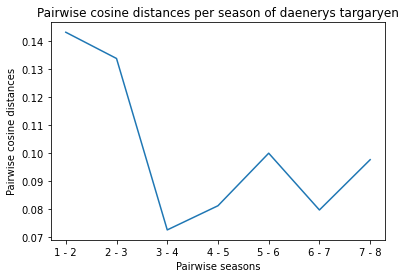

In [ ]:
get_pairwise_distances_and_plot(url, "daenerys targaryen")

From this plot, it is clear that Daenerys' subtitles across the series remain relatively similar, as the cosine distance does not exceed 0.14. However, it is noticeable that her cosine distances increase again in season 7-8, even though they still remain low and similar to the previous seasons. Tapping into the Mad Queen Theory, these distances and this plot may suggest that Daenerys does not suddenly act 'out of character' in season 8, but has actually been slowly growing into a villain throughout the entire series.

#### 2.2.2. Jon Snow

Distance season 1 - season 2: 0.12615449822283265
Distance season 2 - season 3: 0.1450053189607824
Distance season 3 - season 4: 0.12807241144544768
Distance season 4 - season 5: 0.09045051858044806
Distance season 5 - season 6: 0.07703722347340436
Distance season 6 - season 7: 0.07942651064066708
Distance season 7 - season 8: 0.11659346457364184


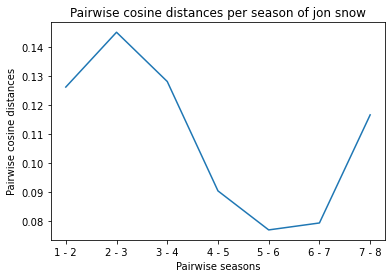

In [ ]:
get_pairwise_distances_and_plot(url, "jon snow")

While the cosine distances for Jon Snow are still on the low side and also do not exceed 0.14, it is clear from this plot that they increase with 0.04 in season 7-8, which may be not surprising, considering that Jon Snow and Daenerys start dating in season 8. 

#### 2.2.3. Cersei Lannister

Distance season 1 - season 2: 0.05931972850278722
Distance season 2 - season 3: 0.07199907391240068
Distance season 3 - season 4: 0.09087824715792236
Distance season 4 - season 5: 0.08251473340464677
Distance season 5 - season 6: 0.08941541612864568
Distance season 6 - season 7: 0.0970886091217874
Distance season 7 - season 8: 0.23287527420257925


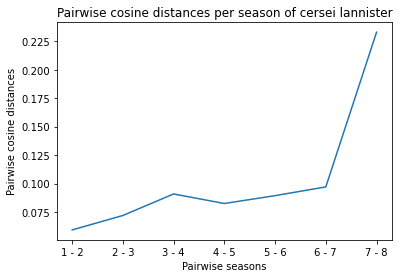

In [ ]:
get_pairwise_distances_and_plot(url, "cersei lannister")

This plot is interesting. While Cersei Lannister's cosine distance remain low as they do not exceed 0.23, the cosine distance between season 7 and 8 increases significantly compared to the previous seasons.

### 2.3. Conclusion
The pairwise cosine distances between each of the seasons for the three analysed characters remain low, and not many conclusions can be drawn from these observations. However, within the window of 0 to 0.2, there are some interesting developments to be noted. First of all, <u>Daenerys'</u> cosine distances are the highest at the beginning of the series, and decrease as the series develops. It is clear that the cosine distances of her subtitles  increase again in the comparison between seasons 7 and 8. This could be interpreted as an argument in favour of the Mad Queen Theory, which hypothesizes that Daenerys does not suddenly act 'out of character' in season 8, but has actually been slowly growing villainous as the series has progressed <span style="color:darkblue">(Willett-Wei & Renfro, 2017)</span>. As for <u>Jon Snow</u>, the pairwise cosine distances between the respective seasons remain relatively low as well, not exceeding 0.14. However, there is a sharp increase in the cosine distance between season 7 and 8. This is interesting, considering that Jon Snow and Daenerys started dating in season 8. Might she have had a "bad" influence on him? <u>Cersei Lannister</u> demonstrates a very interesting plot as well. The pairwise cosine distances of her subtitles between the seasons range between 0 and 0.22. So, while remaining quite low and not really pointing toward a significant difference, these distances are nevertheless higher than the pairwise cosine distances of Jon Snow and Daenerys Targaryen. Moreover, Cersei demonstrates some very low cosine distances (<= 0.1) up until the pairwise comparison between seasons 6 and 7, but demonstrates a steep increase in cosine distance between seasons 7 and 8.

In general, we can say that these pairwise cosine distances between subsequent seasons do not really point toward significant differences. In fact, they remain within a similar range of 0 to 0.22. The trends that are to be observed for Daenerys Targaryen might suggest an argument in favour of the Mad Queen Theory. However, it must be noted that the cosine distances between season 7 and 8 seem to increase for all three analysed characters. Therefore, we cannot draw any conclusions yet.

## 3. Character Networks

After having a closer look at the pairwise cosine distances between subsequent seasons of Daenerys Targaryen, Jon Snow and Cersei Lannister, we have a closer look at the character networks. Two different character networks are created, one for seasons 1 to 7 and one for season 8. Characters are considered to be having a conversation when their utterances follow one another in the data. Scene transitions are not considered, but episode transitions are. The edges in the networks reflect how strong the interaction is between two characters: the more two characters speak to one another, the stronger their interaction. The code that follows is used to initialize the graph data, which is further explored in Gephi. Gephi is used to run the procedure of *Community Detection*, to look for meaningful subcommunities within the network. Characters with a strong connection are grouped together in a subcommunity, marked by colour. 

### 3.1. Preprocessing functions

In [ ]:
import networkx as nx
from itertools import combinations

import collections

In [ ]:
def read_and_preprocess_with_episodes(url):
    df = pd.read_csv(url)
    df['Season'] = df['Season'].str.replace('Season ', '') # removing 'season ', so all that's left is an integer
    df['Season'] = df['Season'].apply(pd.to_numeric) # Changing the column Season from object to integer
    return df

In [ ]:
def remove_and_extract_season_8(df):
    df_all_but_8 = df[df["Season"] != 8]
    df_8 = df[df["Season"] == 8]
    return df_all_but_8, df_8

In [ ]:
df = read_and_preprocess_with_episodes(url)

In [ ]:
df_all_but_8, df_8 = remove_and_extract_season_8(df)

In [ ]:
def get_consecutive_speech_per_episode_in_dataframe(df):
    occurrences_list = []
    for season in df.Season.unique(): # iterating over seasons
        season_df = df[df.Season == season]
        for episode in season_df.Episode.unique(): # iterating over episodes
            episode_df = season_df[season_df.Episode == episode]
            speaker = episode_df.Name.tolist()
            
            occurrences_list.append(speaker)
            
    occurrences = pd.DataFrame(occurrences_list)
    return occurrences, occurrences_list

In [ ]:
# Adding edge to speakers if they follow one another in the speakers list created above
# Number of times the characters were immediatly adjacent in the speakers list is reflected by the weights

# Taking two consecutive speakers, 

def create_graph(occurrences_list, G): # iterate over every episode separately
    for instance in occurrences_list: 
        si, ei = 0, 2
        while ei < len(instance):
            interaction = []
            for character in set(instance[si:ei]):
                interaction.append(character)
            interaction = set(interaction)
            
            # increasing the weights. Weights capture  how often characters interact
            if len(interaction) > 1: 
                for sp1, sp2 in combinations(interaction, 2):
                    
                    # if pair was already present, interaction goes up by 1
                    if G.has_edge(sp1, sp2):
                        G[sp1][sp2]["weight"] += 1
                        
                    # new pair, weight initialized
                    else: 
                        G.add_edge(sp1, sp2, weight = 1)
            si += 1
            ei += 1
            
    print(f"# nodes = {G.number_of_nodes()}, # edges = {G.number_of_edges()}")
    print('# interactions:', G.size(weight='weight'))
    
    return G

In [ ]:
# Calculating node size in character network based on the weights/ the count of the interactions

def calculate_nodesize(G):
    interactions = collections.Counter()
    
    for speaker_i, speaker_j, data in G.edges(data=True):
        interaction_count = data["weight"]
        interactions[speaker_i] += interaction_count
        interactions[speaker_j] += interaction_count
    
    nodesizes = [interactions[speaker]*5 for speaker in G]
    
    return nodesizes 

In [ ]:
def plot_character_network(G, nodesizes):
    # Using NetworkX's plotting functionality to create the visualisation of the character network

    fig = plt.figure(figsize=(15,15))
    pos = nx.spring_layout(G, k=0.5, iterations = 200)
    nx.draw_networkx_edges(G, pos, alpha = 0.4)
    nx.draw_networkx_nodes (G, pos, node_size=nodesizes, alpha=0.4)
    nx.draw_networkx_labels(G, pos)
    

### 3.2. Creating graphs and character networks

#### 3.2.1. Seasons 1 to 7

In [ ]:
G_all_but_8 = nx.Graph() # instantiating a graph for seasons 1-7

In [ ]:
occurrences_all_but_8, occurrences_list_all_but_8 = get_consecutive_speech_per_episode_in_dataframe(df_all_but_8)
#occurrences_all_but_8.head()

In [ ]:
G_all_but_8 = create_graph(occurrences_list_all_but_8, G_all_but_8)

# nodes = 545, # edges = 2319
# interactions: 19925.0


In [ ]:
nodesizes_all_but_8 = calculate_nodesize(G_all_but_8)

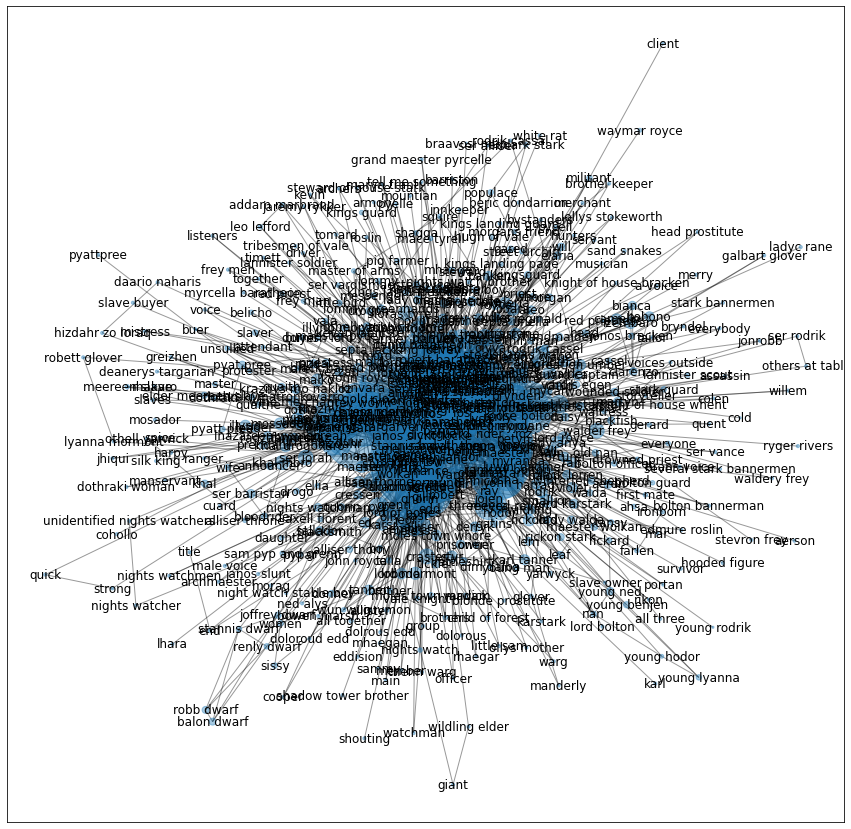

In [ ]:
plot_character_network(G_all_but_8, nodesizes_all_but_8)

#### 3.2.2. Season 8

In [ ]:
G_8 = nx.Graph()

In [ ]:
occurrences_8, occurrences_list_8 = get_consecutive_speech_per_episode_in_dataframe(df_8)

In [ ]:
G_8 = create_graph(occurrences_list_8, G_8)

# nodes = 65, # edges = 237
# interactions: 1169.0


In [ ]:
nodesizes_8 = calculate_nodesize(G_8)

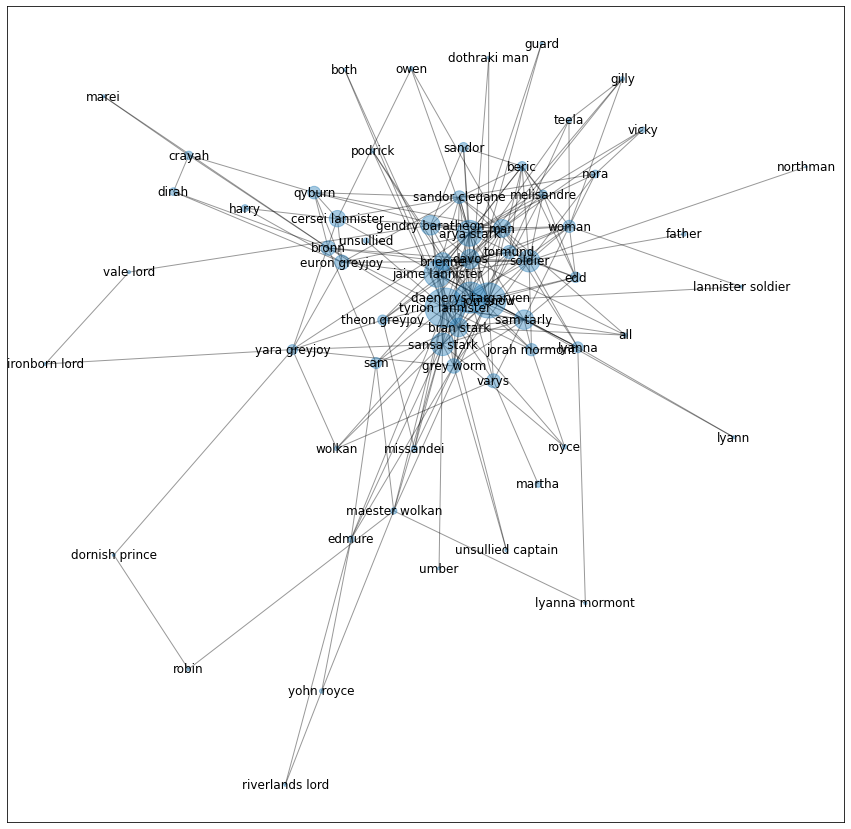

In [ ]:
plot_character_network(G_8, nodesizes_8)

#### 3.2.3. Write to image file

Function to write character network to a local file, in order to analyse it in Gephi. Not necessary to run this.


In [ ]:
def write_network_to_image_file(network, name, path):
    """Function to write character network to a local file, in order to analyse it in Gephi. Not necessary to run."""
    nx.write_gexf(network, path+name)

In [ ]:
path = "/Users/paulineclaes/Documents/dta/CLS/CLS_easter/"

'/Users/paulineclaes/Documents/dta/CLS/CLS_easter'

In [ ]:
write_network_to_image_file(G_all_but_8, "GOT_all_but_8.gexf", path)

### 3.3. GEPHI character networks and subcommunities

After having generated the character networks in this Jupyter Notebook, we exported them to further adjust and analyse in Gephi. The Gephi files are included in this submission folder, and in this notebook we include an image of the Gephi-generated networks to complement our analysis and conclusion. 

#### 3.3.1. Gephi character network seasons 1 to 7

<img src="character_network_1_7.jpeg" alt="Character network seasons 1-7" width="800" height="800"/>


#### 3.3.2. Gephi character network season 8

<img src="character_network_8.jpeg" alt="Character network seasons 8" width="800" height="800"/>


### 3.4. Conclusion

Going back to the Mad Queen theory, we looked for a shift in the subcommunity in which Daenerys is situated. If the Mad Queen theory rings true, we expect to see a shift to a subcommunity with characters that share Daenerys' newfound immorality and drive for power, following the idea of like attracts like. Daenerys’ subcommunity in season 8 does show some characters that were not included in her subcommunity in the previous seasons, such as Jon Snow (which makes sense, as they started dating in season 8), and Sansa Stark. Only Jorah Mormont, who had sworn fealty to Daenerys, remains in Daenerys subcommunity throughout the series. However, most of the new characters that appear in Daenerys subcommunity– Jon Snow, Sansa Stark, Wolkan, and Sam Tarly – are characters that could be described as morally good. The website Fandom describes Wolkan as “a peaceful man who abhors violence” <span style="color:darkblue">(Wolkan, 2021)</span>, while Sam Tarly is “extremely timid, awkward, cowardly, nervous, and easily frightened” <span style="color:darkblue">(Samwell Tarley, 2021)</span>. The only character that remains, except from the two side characters Dothraki man and guard, is Varys. And although his character comes closer to the type of character we expected to find in Daenerys’ subcommunity in season 8, one character with a questionable morale is far from enough to say that the company which she keeps could be seen as a reflection of Daenerys' changing sense of character. 

## 4. Topic Modelling

In what follows, we extract the main topics Daenerys talks about by running a Latent Dirichlet Allocation model - a mixed membership model or "topic model" - on her subtitles. This is an unsupervised model, meaning that the extraction of topics happens without direct supervision or labeling by human readers <span style="color:darkblue">(Karsdorp, Kestemont, & Riddell, 2021)</span>. We run the model separately on Daenerys' subtitles in seasons 1 to 7 and season 8. This way, we hope to find that the topics that she talks about in these seasons are different, which could be an indication for a sudden change in the character of Daenerys. Or the opposite, that the topics extracted from these seasons result to be quite similar, which could point to the idea that Daenerys' actions in season 8 were not that surprising, or The Mad Queen theory.

In [ ]:
# import packages

import sklearn.feature_extraction.text as text
import sklearn.decomposition as decomposition

#!pip install wordcloud
from wordcloud import WordCloud

In [ ]:
df = read_and_preprocess(url)
# df.head()

In [ ]:
df_daenerys = get_relevant_character(df, "daenerys targaryen")
# df_daenerys.head()

In [ ]:
# create separate dataframes for daenerys' subs in seasons 1-7 and season 8
daenerys_all_but_8, daenerys_8 = remove_and_extract_season_8(df_daenerys)

### 4.1. Seasons 1 to 7

In [ ]:
daenerys_all_but_8.head()

,Season,Name,Sentence
176,1,daenerys targaryen,We've been his guests for over a year and he's...
178,1,daenerys targaryen,No.
198,1,daenerys targaryen,I don't want to be his queen. I want to go home.
200,1,daenerys targaryen,I don't know.
297,1,daenerys targaryen,"Thank you, ser. Are you from my country?"


In [ ]:
# create a document term matrix, using a Countvectorizer (see Humanities Data Analysis Chapter 9)

vec_all_but_8 = text.CountVectorizer(
    lowercase=True, 
    stop_words='english',
    min_df=2, # ignore terms that appear in less documents than 2 documents
    max_df=0.95, # ignore terms that appear in more than 95% of the documents
    ngram_range=(1,2), # we are looking for unigrams and bigrams
    token_pattern=r'(?u)\b\w\w\w+\b') # each term must consist of at least 3 characters 
                                      # (otherwise 'll' and 've' will be included in most of the topics)

dtm_all_but_8 = vec_all_but_8.fit_transform(daenerys_all_but_8['Sentence'])

print(f'Shape of document term matrix: {dtm_all_but_8.shape}'
      f'\nNumber of tokens: {dtm_all_but_8.sum()}')

Shape of document term matrix: (916, 778)
Number of tokens: 3724


In [ ]:
# initiate a LatentDirichletAllocation model and fit it on the document term matrix

model = decomposition.LatentDirichletAllocation(
    n_components=10, # number of topics
    learning_method='online', 
    random_state=1) 

document_topic_distributions_all_but_8 = model.fit_transform(dtm_all_but_8)

In [ ]:
# create a vocabulary

vocabulary_all_but_8 = vec_all_but_8.get_feature_names()
print(vocabulary_all_but_8[:10])

['able', 'admit', 'advice', 'advise', 'advisor', 'afraid', 'aggo', 'aggo kovarro', 'alive', 'allies']


In [ ]:
# check if things are working correctly

assert model.components_.shape == (10, len(vocabulary_all_but_8))
assert document_topic_distributions_all_but_8.shape == (dtm_all_but_8.shape[0], 10)

In [ ]:
# convert the arrays which hold the parameter estimates into dataframes

topic_names_all_but_8 = [f'Topic {k}' for k in range(10)]
topic_word_distributions_all_but_8 = pd.DataFrame(
    model.components_, columns=vocabulary_all_but_8, index=topic_names_all_but_8)
document_topic_distributions_all_but_8 = pd.DataFrame(
    document_topic_distributions_all_but_8, columns=topic_names_all_but_8, index=daenerys_all_but_8.index)

In [ ]:
# estimates of a word in the vocabulary belonging to a specific topic

topic_word_distributions_all_but_8.head()

,able,admit,advice,advise,advisor,afraid,aggo,aggo kovarro,alive,allies,...,wrong,xaro,xaro xhoan,xhoan,xhoan daxos,year,years,yes,young,yunkai
Topic 0,0.102595,0.101791,0.101357,0.101274,0.101737,0.101973,0.101686,0.101132,0.898726,0.102782,...,0.102190,0.101506,0.101327,0.101780,0.101261,0.103039,2.465551,0.101271,0.101660,0.108512
Topic 1,0.101471,0.101645,0.101392,0.101481,0.101373,2.699145,0.101496,0.101420,0.101336,1.651601,...,0.107428,0.101541,0.101306,0.101333,0.101481,0.101336,0.102014,0.101304,0.101253,0.105965
Topic 2,0.101320,0.101909,0.101326,1.004188,0.101272,0.116781,0.101342,0.101399,0.101165,0.103093,...,1.304364,0.101627,0.101731,0.101259,0.101128,0.969202,0.103516,0.101359,0.101256,3.830180
Topic 3,0.101306,0.101477,0.101835,0.107628,0.101522,0.103752,0.107649,0.107740,0.103531,1.512712,...,0.107955,0.101695,0.101471,0.101441,0.101719,0.101612,1.230170,0.101328,0.990852,0.968275
Topic 4,0.101463,0.101879,0.101292,0.101416,0.101548,0.102123,0.101637,0.101575,0.101505,0.101174,...,0.102863,0.898539,0.101487,0.101463,0.101303,2.567384,0.101377,16.000993,0.101872,0.106535


In [ ]:
# estimates of a document (a sub in the column 'Sentence') belonging to a specific topic

document_topic_distributions_all_but_8.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
176,0.025000,0.025000,0.025001,0.025005,0.774994,0.025000,0.025000,0.025000,0.025000,0.025000
178,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
198,0.014286,0.014291,0.585716,0.157136,0.014286,0.014286,0.014286,0.014286,0.014286,0.157141
200,0.774964,0.025000,0.025019,0.025000,0.025008,0.025000,0.025000,0.025009,0.025000,0.025000
297,0.025004,0.025000,0.274995,0.025000,0.025000,0.025000,0.025000,0.025001,0.525001,0.025000


### 4.2. Season 8

In [ ]:
daenerys_8.head()

,Season,Name,Sentence
22455,8,daenerys targaryen,"Thank you for inviting us into your home, Lady..."
22476,8,daenerys targaryen,Whatever they want.
22622,8,daenerys targaryen,Your sister doesn't like me.
22624,8,daenerys targaryen,She doesn't need to be my friend but I am her ...
22625,8,daenerys targaryen,How many today?


In [ ]:
# create a document term matrix, using a Countvectorizer (see Humanities Data Analysis Chapter 9)

vec_season_8 = text.CountVectorizer(
    lowercase=True, 
    stop_words='english',
    min_df=2, # ignore terms that appear in less documents than 2 documents
    max_df=0.95, # ignore terms that appear in more than 95% of the documents
    ngram_range=(1,2), # we are looking for unigrams and bigrams
    token_pattern=r'(?u)\b\w\w\w+\b') # each term must consist of at least 3 characters 
                                      # (otherwise 'll' and 've' will be included in most of the topics)

dtm_season_8 = vec_season_8.fit_transform(daenerys_8['Sentence'])

print(f'Shape of document term matrix: {dtm_season_8.shape}'
      f'\nNumber of tokens: {dtm_season_8.sum()}')

Shape of document term matrix: (132, 122)
Number of tokens: 356


In [ ]:
# initiate a LatentDirichletAllocation model and fit it on the document term matrix

model = decomposition.LatentDirichletAllocation(
    n_components=10, # number of topics
    learning_method='online', 
    random_state=1) 

document_topic_distributions_season_8 = model.fit_transform(dtm_season_8)

In [ ]:
# create a vocabulary

vocabulary_season_8 = vec_season_8.get_feature_names()
print(vocabulary_season_8[:10])

['abandoned', 'aren', 'army', 'baratheon', 'betrayed', 'blood', 'break', 'break wheel', 'brother', 'cersei']


In [ ]:
# check if things are working correctly

assert model.components_.shape == (10, len(vocabulary_season_8))
assert document_topic_distributions_season_8.shape == (dtm_season_8.shape[0], 10)

In [ ]:
# convert the arrays which hold the parameter estimates into dataframes

topic_names_season_8 = [f'Topic {k}' for k in range(10)]
topic_word_distributions_season_8 = pd.DataFrame(
    model.components_, columns=vocabulary_season_8, index=topic_names_season_8)
document_topic_distributions_season_8 = pd.DataFrame(
    document_topic_distributions_season_8, columns=topic_names_season_8, index=daenerys_8.index)

In [ ]:
# estimates of a word in the vocabulary belonging to a specific topic

topic_word_distributions_season_8.head()

,abandoned,aren,army,baratheon,betrayed,blood,break,break wheel,brother,cersei,...,trusted,trusts,truth,tyrant,unsullied,varys,war,wheel,world,yes
Topic 0,0.169577,0.154529,0.155051,0.151693,1.056894,0.153600,0.168411,0.145926,0.642415,0.166951,...,0.155853,0.163935,0.150141,0.147633,0.151414,1.078395,0.156325,0.150078,0.150710,0.164291
Topic 1,0.168020,0.987532,0.169103,0.159140,0.154941,0.157142,0.160019,0.159749,1.077722,0.150731,...,0.153496,0.624171,0.160465,0.145734,0.156018,0.153670,0.155359,0.160732,0.642903,0.165957
Topic 2,0.627082,0.158105,0.163831,0.631685,0.610506,0.167611,0.153044,0.165158,0.361865,0.165976,...,0.165046,0.165647,1.038166,1.069722,1.061578,0.617943,0.630136,0.473899,0.171664,0.158689
Topic 3,0.157736,0.141911,0.163036,0.155362,0.151839,0.160509,0.161133,0.164183,2.703741,0.158302,...,0.162507,0.156182,0.161670,0.149766,0.160169,0.156748,0.624448,0.147919,0.232599,0.162749
Topic 4,0.620417,0.163624,0.159046,0.158953,0.155483,1.091985,0.161055,0.157186,0.148843,0.623175,...,0.157134,0.158474,0.167880,0.620817,0.157220,0.156144,0.166235,0.160705,0.157564,0.633141


In [ ]:
# estimates of a document (a sub in the column 'Sentence') belonging to a specific topic

document_topic_distributions_season_8.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
22455,0.025000,0.025001,0.025000,0.774985,0.025003,0.025000,0.025011,0.025000,0.025,0.025
22476,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100,0.100
22622,0.025000,0.025011,0.025000,0.025000,0.025001,0.774985,0.025002,0.025000,0.025,0.025
22624,0.020006,0.819988,0.020003,0.020000,0.020000,0.020000,0.020001,0.020001,0.020,0.020
22625,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100,0.100


### 4.3. Visualization

#### 4.3.1. Topic models

The `topic_word_distributions` dataframes we created above show the estimates of a word in the vocabulary of Daenerys belonging to a specific topic. The `document_topic_distributions` dataframes show the estimates of a document - i.e. a subtitle in the column 'Sentence' - belonging to a specific topic. However, these estimates do not tell us much about the actual topics that have been generated. To get a clear idea of what those are, we set up a function called `display_topics`, which will display the first ten words of each topic and their weights in a dataframe. 

In [ ]:
def display_topics(model, vectorizer, top_words=10):
    features = vectorizer.get_feature_names()
    topic_dict = {}
    for n, topic in enumerate(model.components_):
        topic_dict['Topic {} words'.format(n)] = ['{}'.format(features[i]) for i in topic.argsort()[:-top_words - 1:-1]]
        topic_dict['Topic {} weights'.format(n)] = ['{:.1f}'.format(topic[i]) for i in topic.argsort()[:-top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

##### 4.3.1.1. Seasons 1 to 7

In [ ]:
display_topics(model, vec_all_but_8)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,carry,1.5,betrayed,17.2,captain,1.5,alive,2.7,come,1.6,changed,2.4,armies,17.9,baby,18.0,arms,1.1,born,33.2
1,care,1.1,argue,1.6,breaker,1.5,collect,1.5,burn,1.5,comes,1.5,closer jon,1.5,betray,17.9,ask,0.6,country,18.0
2,boys,1.1,awaiting,1.1,bring peace,1.5,blood blood,1.1,chains,1.4,closer,1.4,ask,1.5,blood,2.0,away,0.6,babies,17.1
3,comes,1.1,alive,1.1,brother,1.5,coming,1.1,angry,1.1,bow,1.1,capital,1.5,banners,1.5,captain,0.6,counseled,16.9
4,couldn,1.1,admit,1.0,belong,1.1,bay,1.1,afraid,1.1,claim,1.1,bury,1.1,approach,1.5,country,0.2,aggo kovarro,16.7
5,command,1.1,country,0.6,contract,1.1,beasts,1.1,changed,1.1,bring,1.1,begin,1.1,advise,1.1,asked,0.2,aggo,16.7
6,believe,1.1,bend knee,0.6,believed,1.1,came,0.8,beginning,1.1,collect,1.1,bring peace,1.1,conquer,1.1,body,0.2,bought,16.7
7,advisor,1.1,clothes,0.6,black salt,1.1,asking,0.8,cave,0.6,boat,1.1,boat,1.1,allies,1.1,assassins,0.2,andals,16.7
8,body,0.8,continue,0.6,control,1.1,bring peace,0.7,course,0.6,ancestor,1.1,beautiful,1.1,approve,1.1,course,0.2,camp,0.3
9,army,0.7,buy,0.6,bad,1.1,ancient,0.6,choices,0.6,best,1.1,alive,1.1,carrying,0.6,children,0.2,breaker chains,0.2


##### 4.3.1.2. Season 8

In [ ]:
display_topics(model, vec_season_8)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,right,1.5,known,17.2,people,1.5,brother,2.7,time,1.6,sister,2.4,don,17.9,good,18.0,dracarys,1.1,little,33.2
1,queen,1.1,doesn,1.6,love,1.5,throne,1.5,mercy,1.5,told,1.5,thousand,1.5,know,17.9,enemies,0.6,world,18.0
2,lord,1.1,friend,1.1,man,1.5,liberated,1.1,ser,1.4,thought,1.4,enemies,1.5,let,2.0,gendry,0.6,girl,17.1
3,told,1.1,brother,1.1,men,1.5,took,1.1,dead,1.1,long,1.1,north,1.5,hand,1.5,people,0.6,wheel,16.9
4,varys,1.1,aren,1.0,king landing,1.1,iron,1.1,blood,1.1,think,1.1,mind,1.1,didn,1.5,world,0.2,break wheel,16.7
5,torgo,1.1,world,0.6,tyrant,1.1,iron throne,1.1,sister,1.1,make,1.1,jon snow,1.1,baratheon,1.1,family,0.2,break,16.7
6,kind,1.1,knew,0.6,king,1.1,murdered,0.8,jorah,1.1,throne,1.1,man,1.1,trusted,1.1,liked,0.2,little girl,16.7
7,betrayed,1.1,throat,0.6,landing,1.1,father,0.8,sansa,0.6,like,1.1,like,1.1,cersei,1.1,fear,0.2,count,16.7
8,liked,0.8,trusts,0.6,unsullied,1.1,man,0.7,yes,0.6,citadel,1.1,jon,1.1,didn know,1.1,yes,0.2,need,0.3
9,dragons,0.7,moment,0.6,grip,1.1,city,0.6,storm,0.6,knew sister,1.1,brother,1.1,robert,0.6,son,0.2,loyal,0.2


##### 4.3.1.3. Conclusion
We observe some differences between the topics generated out of Daenerys' subtitles in seasons 1 to 7 and her subtitles in season 8. However, the topics itself and the differences between them are difficult to interpret, as they contain a lot of character names, such as "*varys*" and "*jorah*", and words that do not carry much meaning, such as "*knew*" and "*like*". So, to get a better look at the topics that Daenerys talks about, we will make word clouds, which are a bit easier on the eye. 

#### 4.3.2. Word Clouds

In what follows we will show two word clouds, one generated out of the vocabulary we constructed for season 1 to 7, and another one for the vocabulary of season 8. These word clouds will include the 100 most frequent words. As we will see, the words will all have different sizes, as their size is adapted to their frequency: the bigger a word, the more often it occurs. 

In [ ]:
vocab_string_all_but_8 = ",".join(vocabulary_all_but_8) # join Daenerys' vocabulary in season 1-7 into one large string
vocab_string_season_8 = ",".join(vocabulary_season_8) # join Daenerys' vocabulary in season 8 into one large string

In [ ]:
wordcloud = WordCloud(background_color="white", 
                      max_words=100,  # the 100 most frequent words
                      contour_width=3, 
                      contour_color="steelblue")

##### 4.3.2.1. Seasons 1 to 7

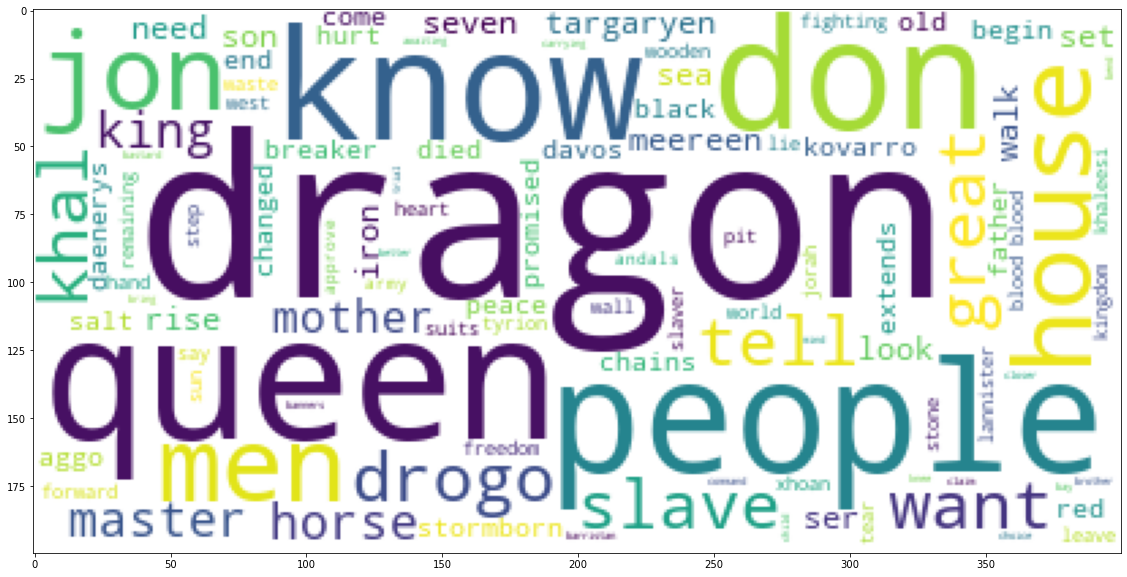

In [ ]:
# season 1-7

wordcloud_1_7 = wordcloud.generate(vocab_string_all_but_8)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_1_7)

##### 4.3.2.2. Season 8

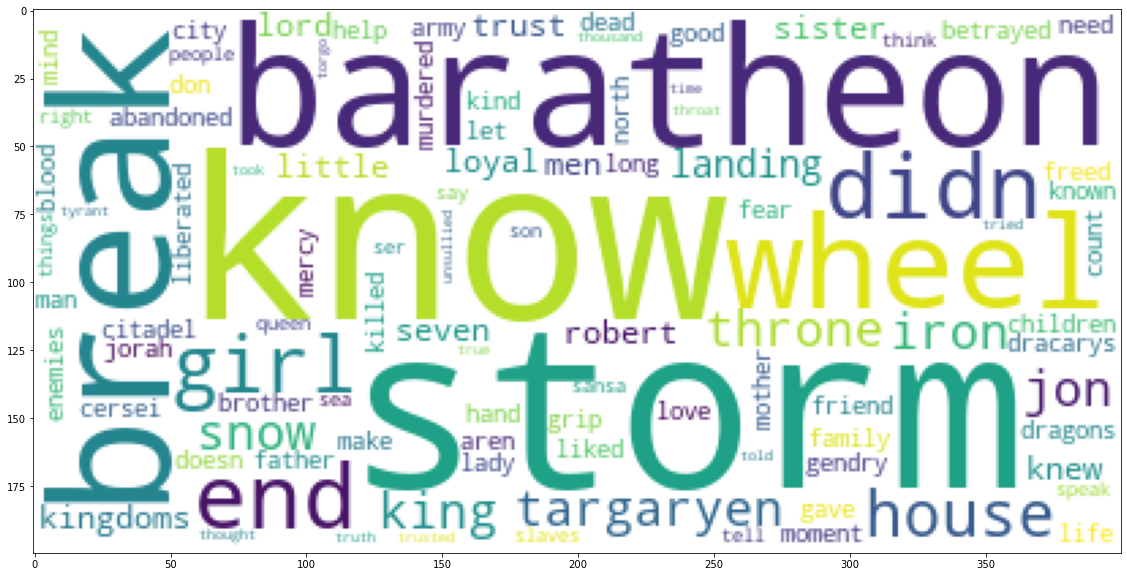

In [ ]:
wordcloud_8 = wordcloud.generate(vocab_string_season_8)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_8)

### 4.4. Conclusion

As we can see, the word cloud of Daenerys' vocabulary in season 1 to 7 and the one of her vocabulary in season 8 differ quite a bit. Words that are of great importance in season 1 to 7, such as "dragon", "queen", and "people", move to the background in season 8, as words such as "storm", "baratheon", and "wheel" replace them as main constituents of the word cloud. 

As the four of us have not yet seen the Game of Thrones series, we asked fans of the series to shed some light on how to interpret the differences between the two word clouds. They were able to tell us the following:

- The fact that the word "dragon" features so prominently in the word cloud of seasons 1 to 7 would be because Daenerys allegedly calls herself the "mother of dragons", as she owns three dragons. As two of these dragons die in season 7, this could explain the absence of the word "dragon" in the word cloud of season 8. 

- During the first seasons of the series, Daenerys' objective is to free slaves and to kill their owners. Because of this, she calls herself the "breaker of chains", which could explain the presence of the words "breaker" and "chains" in the word cloud of season 1 to 7.

- The Iron Throne is the throne upon which the monarch of the Seven Kingdoms sits. As we can see, the Iron Throne always played a big part in the series: the words "iron" and "throne" are present in both the word cloud of seasons 1 to 7 and the one of season 8. However, it should be noted that the size of these words increases in the word cloud of season 8, meaning they occur more often. This would make sense as in season 8, Daenerys starts to act upon her desire to reign the Seven Kingdoms. Interestingly, the word "queen" decreases in size in the word cloud of season 8, despite of her aspiration of becoming queen. 

- The words "break" and "wheel" in the word cloud of season 8 come from Daenerys' ideas of "breaking the wheel". According to her, the Seven Kingdoms is a wheel that keeps spinning, by which she refers to the fact that the house occupying the throne keeps changing. In her opinion, the common people have become victims of this political game, and she wants to save them from it by "breaking the wheel". The way to break the wheel, according to Daenerys, is by her becoming queen. However, on her way to throne she acts ruthlessly. She burns down a whole city, by which she kills many common people. Therefore, it could be questioned if she really wants to save the common people from the political game, or that she is just hungry for power. 

- The House of Baratheon is the house that removed Daenerys' father from the Iron Throne. According to Daenerys, the House of Targaryen still has the right to the throne, and as she is the only decendent of the House of Targaryen, she is thus the only rightful queen. So, the fact that the word "baratheon" plays such an important role in the word cloud of season 8, again has to do with Daenerys' hunger for power. 

- The biggest word in the word cloud of season 8, "storm", is most probably related to the fact that Daenerys is sometimes called Daenerys Stormborn, as she was born during a heavy storm. 

In conclusion, the main constituents of the word cloud of season 8 are words that are related to Daenerys' desire to rule the Seven Kingdoms. This shift from the "breaker of chains" who is fighting for a good cause to the "rightful queen" who is hungry for power, could be an indication that she might indeed have suddenly changed into a villainous, brutal conqueror in the last season of the series. 

## 5. Principal Component Analysis

Now that the prominent topics have been established, it might be interesting to verify if and how much the embeddings of certain topics have changed over time. The vocabulary that follows is handpicked, based on the fact whether a word is meaningful or not. We are aware of a certain bias that might come with this vocabulary since it is handpicked and not based on decent scientific research.

The idea of this PCA is that a selected vocabulary of words will be in a different vector space when you compare seasons 1 to 7 to season 8. The most relevant part for this research is to know whether and how much the vector space of the word 'daenerys' has changed. If there is not an obvious difference, this could suggest that Daenerys' character has always been like she is in season 8 (the Mad Queen Theory). If the PCA shows an obvious difference between seasons 1 to 7 and 8, this could fund the opposite, mainly that Daenerys indeed has suddenly acted out of character in season 8.

For this part of the research; when we tried to create the two PCAs, it turned out that there wasn't enough data for season 8 if we counted in only the subtitles uttered by Daenerys. The result was a graph with most of the vocabulary as a dense unreadable center somewhere, with a few words as outliers around it. 

For this reason, we decided to include the subtitles of all the characters of the series, instead of the subtitles only uttered by Daenerys.

In [ ]:
# Importing relevant packages:

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

import sklearn.feature_extraction.text as text
import sklearn.preprocessing as preprocessing
import sklearn.decomposition

In [ ]:
# importing data and dropping columns that will not be used.
df = read_and_preprocess(url)

# creating a subdataframe  with one row per season.
df = merge_subs_per_season(df)

In [ ]:
all_but_8, only_8 = remove_and_extract_season_8(df)

In [ ]:
# Establishing a vocabulary, based on the topics from the topic modelling part: 
vocab = ["viserys", "daenerys", "brother", "sister", "jorah", "camp", "woman", "fear", "people", "queen", "won", "life",
         "men", "king", "chair", "kill", "hurt", "dragon", "kingdoms", "killed", "gone", 
         "right", "betrayed", "lord", "friend", "kind", "help", "throne", "father", "army", "blood", "mother", "love", "good", "trusted", "enemies", 
         "enemy", "power", "son", "leave"]

In [ ]:
# Turning the values of the column 'Sentence' into a list:
documents_1_7 = create_list_of_subs(all_but_8)
documents_8 = create_list_of_subs(only_8)

### 5.1. Seasons 1 to 7

In [ ]:
# Obtaining the word embeddings for the words in the vocabulary:

vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab) # creating a vectorizer, transforming the text into meaningful vectors

v_documents = vectorizer.fit_transform(documents_1_7).toarray() # fitting the vectorizer to the sentences from season 1-7
v_documents = preprocessing.normalize(v_documents.astype(np.float64), 'l1') # normalizing the values

scaler = preprocessing.StandardScaler()
v_documents = scaler.fit_transform(v_documents)

print(vectorizer.get_feature_names()[:5])
print(f'N={v_documents.shape[0]} documents with '
      f'V={v_documents.shape[1]} features.')

['viserys', 'daenerys', 'brother', 'sister', 'jorah']
N=941 documents with V=40 features.


In [ ]:
pca = sklearn.decomposition.PCA(n_components=2).fit(v_documents) # establishing the number of the components for our analysis (in this case 2 dimensions)
comps = pca.components_.transpose() # transposing the components to make the dimensions match

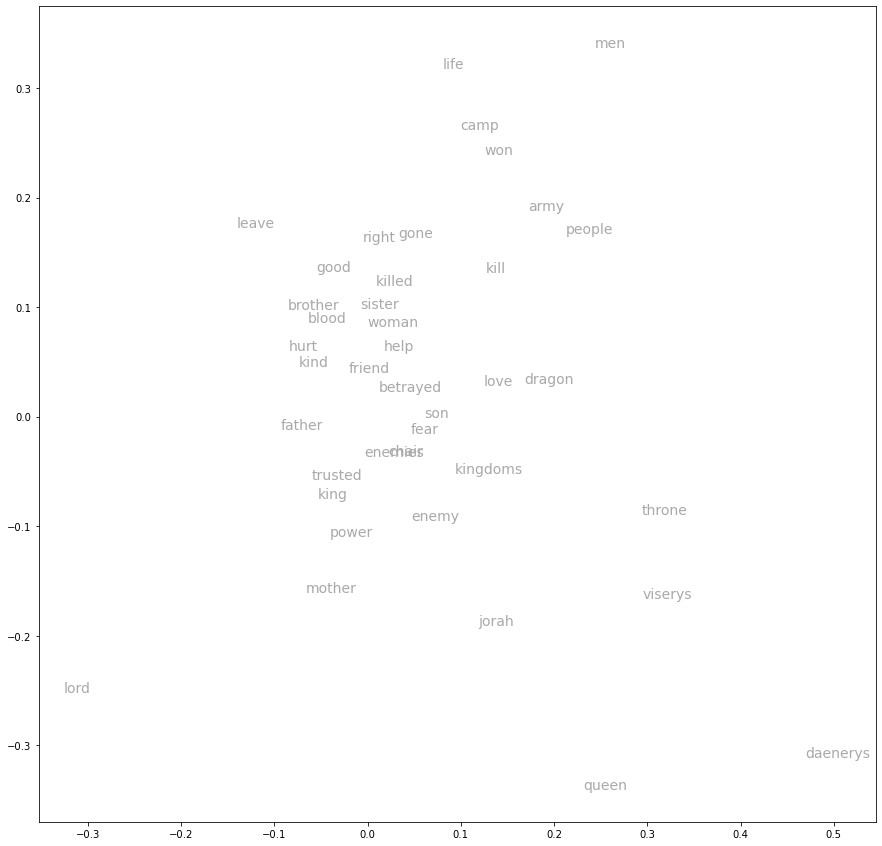

In [ ]:
# Plotting the loadings
l1, l2 = comps[:, 0], comps[:, 1]

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(l1, l2, facecolors='none')

for x, y, l in zip(l1, l2, vocab):
    ax.text(x, y, l, ha='center', va='center', color='darkgrey', fontsize=14)

### 5.2. Season 8

In [ ]:
# Obtaining the word embeddings for the words in the vocabulary:

vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab) # creating a vectorizer

v_documents = vectorizer.fit_transform(documents_8).toarray() # fitting the vectorizer to the sentences from season 8
v_documents = preprocessing.normalize(v_documents.astype(np.float64), 'l1') # normalizing the values

scaler = preprocessing.StandardScaler()
v_documents = scaler.fit_transform(v_documents)

print(vectorizer.get_feature_names()[:5])
print(f'N={v_documents.shape[0]} documents with '
      f'V={v_documents.shape[1]} features.')

['viserys', 'daenerys', 'brother', 'sister', 'jorah']
N=65 documents with V=40 features.


In [ ]:
# Creating a PCA
pca = sklearn.decomposition.PCA(n_components=2).fit(v_documents) # establishing the number of the components for our analysis (in this case 2 dimensions)
comps = pca.components_.transpose() # transposing the components to make the dimensions match


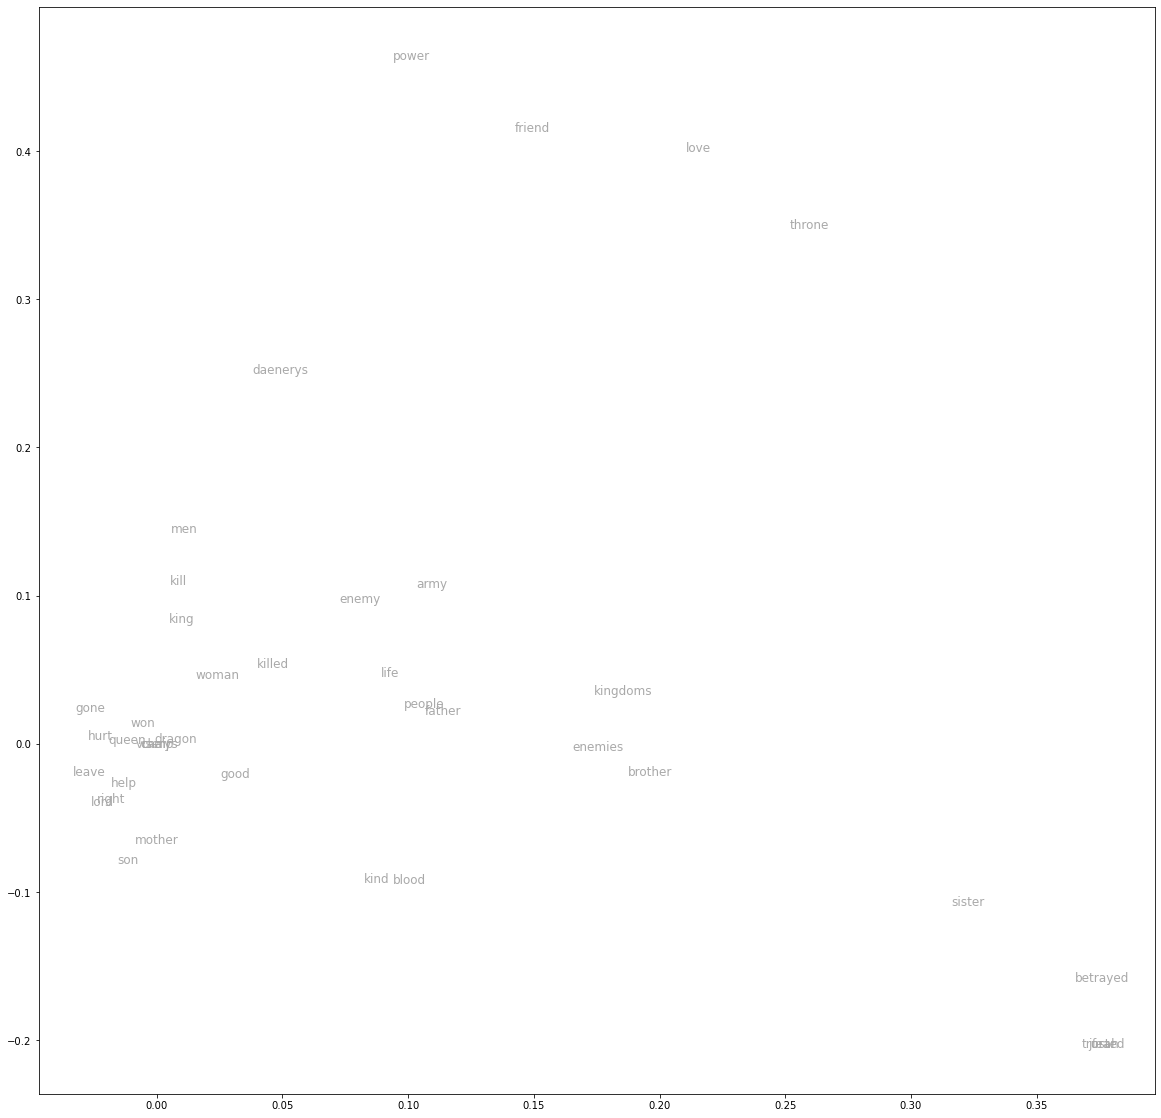

In [ ]:
# Plotting the loadings
l1, l2 = comps[:, 0], comps[:, 1]

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(l1, l2, facecolors='none')

for x, y, l in zip(l1, l2, vocab):
    ax.text(x, y, l, ha='center', va='center', color='darkgrey', fontsize=12)

### 5.3. Conclusion

The two PCA analyses comparing seasons 1 to 7 to season 8 brought up some interesting differences. When observing the word 'daenerys' in the PCA of seasons 1 to 7, the closest words in the vector space are 'viserys' (her brother), 'queen' and 'throne'. Furthermore, 'daenerys' is located somewhere along the periphery of the graph. When observing 'daenerys' in season 8, a change of vector space is clearly visible. The word 'daenerys' has shifted from the outskirts to a somewhat more central position. More importantly, the closest words to 'daenerys' have changed to 'men', 'kill', 'enemy' and 'army'. 

This observation could indicate that Daenerys might have been focused on the throne all along - which fits the Mad Queen theory narrative -  but only shifted to a more brutal and villainous way of obtaining the throne in season 8. From this perspective, we could assume that the Mad Queen theory might actually have some grounds. On the other hand, we observed that there is an important change in the vector space of Daenerys in season 8 as opposed to that of seasons 1 to 7, indicating that the realisation of her absolute desire to rule in season 8 might have undergone an important shift. In that perspective, it is comprehensible that her role might have come as a surprise for some, while having been anticipated by others.

## 6. Overall conclusion


In this project paper, we aimed to investigate a prominent point of criticism on the last season of Game of Thrones. Many fans and fora address that Game of Thrones’ season 8 brushed aside some key character development moments in general and for the character of Daenerys Targaryen in particular, and argue that Daenerys, who once was the series’ most beloved character, has suddenly turned into a villainous and brutal conqueror in season 8. However, some allegedly sharp-eyed fans have noted that Daenerys actually might have been a cruel conqueror all along, which is a perspective that is also known as ‘the Mad Queen theory’. 
We have investigated this claim by analysing the series’ subtitles by means of a Vector Space Model to measure the cosine distance between the seasons’ subtitles (section 2), character networks (section 3), topic modelling using Latent Dirichlet Allocation (section 4), and a Principal Component Analysis (section 5). 

The calculated pairwise cosine distances between subsequent seasons for the character of  Daenerys Targaryen demonstrate a trend that might suggest an argument in favour of the Mad Queen Theory, in that the cosine distances between her subtitles remain within a range of 0 to 0.14. However, it should be noted that the pairwise cosine distances for both Jon Snow and Cersei Lannister remain relatively low as well, namely within a range of 0 to 0.22. In addition, one should take into account that the cosine distances between season 7 and 8 seem to increase for all three analysed characters. Therefore, in general, the pairwise cosine distances might point toward the Mad Queen theory, but do not allow us to draw any significant conclusions.

By analysing character networks and subcommunities for Daenerys Targaryen, we looked for possible shifts in the subcommunity in which Daenerys is situated. More specifically, we expected to see a shift to a subcommunity with characters that share Daenerys’ newfound immorality and drive for power. However, most of the new characters that appear in her season 8 subcommunity, could be described as morally good, except for one. We conclude that one character with a questionable morale is not enough to assume that the company which she keeps should be seen as a reflection of Daenerys’ changing sense of character. 
Subsequently, we performed topic modelling by running a Latent Dirichlet Allocation model on Daenerys’ subtitles, in order to verify whether she talks about similar or different topics across the seasons, which could indicate that Daenerys has always been villainous (the Mad Queen theory), or could suggest a sudden change in her character in season 8. After that, the prominent topics are visualised in both data frames and in word clouds. From these, it is clear that Daenerys’ vocabulary in seasons 1 to 7 and in season 8 differ quite a bit. More specifically, her season 8 vocabulary relates to Daenerys’ desire to rule the Seven Kingdoms, while the vocabulary from seasons 1 to 7 conveys her more as ‘the breaker of chains’ who is fighting for a good cause. In this perspective, we conclude that the topic modelling using LDA indicates that Daenerys might indeed have suddenly changed into a villainous, brutal conqueror in the last season of the series.

Finally, using Principal Component Analysis, we aim to research whether and how much the vector space of the word ‘daenerys’ has changed. This analysis indicates that the vector spaces of seasons 1 to 7 and season 8 differ quite obviously. First of all, the word ‘daenerys’ has moved from the periphery of the graph to a more central position. In addition, the closest words to ‘daenerys’ in the vector space of seasons 1 to 7 are ‘viserys’, ‘queen’, and ‘throne’, and have been replaced by ‘men’, ‘kill’, ‘enemy’ and ‘army’ in the vector space of season 8. This last observation might indicate that she has always been focused on the throne during the entire series, but might have shifted to a more brutal and villainous way of obtaining that power.  

In conclusion, the analysis of Daenerys’ subtitles in particular and the series’ subtitles in general by means of pairwise cosine distances (Vector Space Model), character networks, topic modelling and a Principal Component Analysis has led us to conclude that there might be some fundamental grounds for the Mad Queen theory, while there is also reason to believe that her manifestation as a brutal conqueror in season 8 might have come as a surprise to many fans. However, we believe that an analysis of the subtitles might not be all there is to it. The techniques and data used in this research might point toward trends, but demand a more thorough and robust analysis to draw a ripe conclusion. 


## References

- Frydenborg, B. E. (2021, March 4). Yes, the final season of Game of Thrones was a chaotic mess, and it was glorious. Retrieved April 18, 2021, from https://winteriscoming.net/2019/10/06/game-of-thrones-season-8-glorious-mess/

- Karsdorp, F., Kestemont, M., & Riddell, A. (2021). Humanities Data Analysis. Amsterdam, Netherlands: Amsterdam University Press.

- Samwell Tarley. (2021, April 13). In  *Fandom*. Retrieved April 20, 2021, from https://gameofthrones.fandom.com/wiki/Samwell_Tarly?action=history

- Walsingham, V. (2019, May 17). The real change in Game of Thrones’ Daenerys is how other characters see her. Retrieved April 18, 2021, from https://www.theverge.com/2019/5/17/18629561/game-of-thrones-got-season-8-hbo-final-daenerys-targaryen-the-bells-kings-landing-villain


- West, T. (2020, May 16). Game Of Thrones: D&D Moral Alignments Of The Main Characters. Retrieved April 16, 2021, from https://www.screenrant.com/game-of-thrones-dungeons-dragons-moral-alignments-main-characters/

- Willett-Wei, M., & Renfro, K. (2017, August 9). The latest “Game of Thrones” battle bolsters a theory about Daenerys heading down a villainous path. Retrieved April 16, 2021, from https://www.insider.com/game-of-thrones-evil-daenerys-targaryen-theory-2017-8

- Wolkan. (2021, January 31). in *Fandom*. Retrieved April 20, 2021, from https://gameofthrones.fandom.com/wiki/Wolkan.